In this notebook, we will do the Exploratory data analysis of our project after the dataset that we have filtered.
An important note is that the dataset comes from the LINCS data that is itself very clean. As a reminder the values that we have for the genes id are the difference of the genes expression before and after a certain treatment that is names under pertu_iname. These values have been normalised using the z-score

Gather dataset

In [1]:
import pandas as pd
from google.colab import drive

In [2]:
drive.mount('/content/drive')
path_to_file = '/content/drive/MyDrive/filtered_final_dataset.parquet'
genes_expression = pd.read_parquet(path_to_file)
genes_expression.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id,embedding,780,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,LJP005_A375_24H:A03,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A03|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",-0.154526,...,0.133007,-0.357345,-0.074198,0.366143,0.323543,0.198538,-0.075226,-1.076814,-0.240803,0.105998
1,LJP005_A375_24H:A04,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A04|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",0.113874,...,-0.539718,-0.449374,0.138172,0.520369,0.197536,-0.177739,0.063853,-0.904253,0.040530,-0.619656
2,LJP005_A375_24H:A05,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A05|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",-0.038252,...,-0.276955,-0.185521,0.429882,0.008059,-0.216541,0.887142,0.156324,-0.939757,-0.093534,-0.260954
3,LJP005_A375_24H:A06,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A06|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",0.466993,...,1.492237,-0.136315,0.920847,0.427959,-0.354371,0.903572,0.505928,-0.468805,1.793977,-0.642835
4,LJP005_A375_24H:A07,BRD-K76908866,CP-724714,trt_cp,A375,10.0 um,24 h,LJP005_A375_24H_X1_B19:A07|LJP005_A375_24H_X2_...,"[0.29808575, 0.10792902, -0.66687685, 0.768152...",-1.462477,...,1.698389,0.419330,0.509720,0.385096,-6.896286,0.728512,-0.183455,0.852644,1.406259,-0.416583


#1 Checking missing values

In [3]:
genes_expression.isna().sum().sum()

np.int64(0)

There are no missing value, the dataset

# 2 Outliers we will check if there are outliers the PCA of PC1 and PC2 and check if there are outliers in there

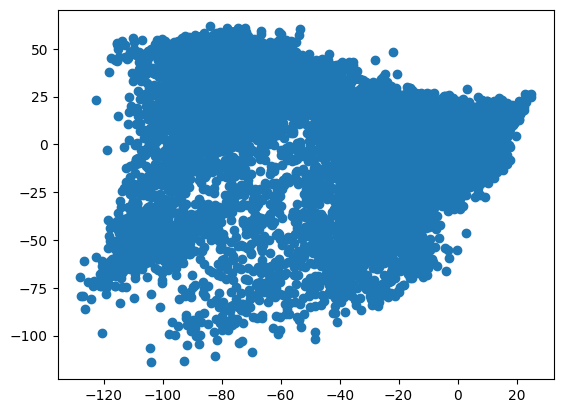

In [4]:
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

outlier = genes_expression.drop(columns=['sig_id','pert_id','pert_iname','pert_type','cell_id','pert_idose','pert_itime','distil_id','embedding'])

pca = PCA(n_components=2)
coords = pca.fit_transform(outlier)

plt.scatter(coords[:,0], coords[:,1])


We conclude based on the PCA representation that we do not observe samples behaving as outliers.There is one main clusters and all the values are at reasonabble distance from it in the two first component.

# 3 Distribution analysis. We will see the global distribution accross all genes of the difference before vs after the treatment, then we will display the difference of absolute change to assess the effect of a certain drug.


Text(0, 0.5, 'Occurence')

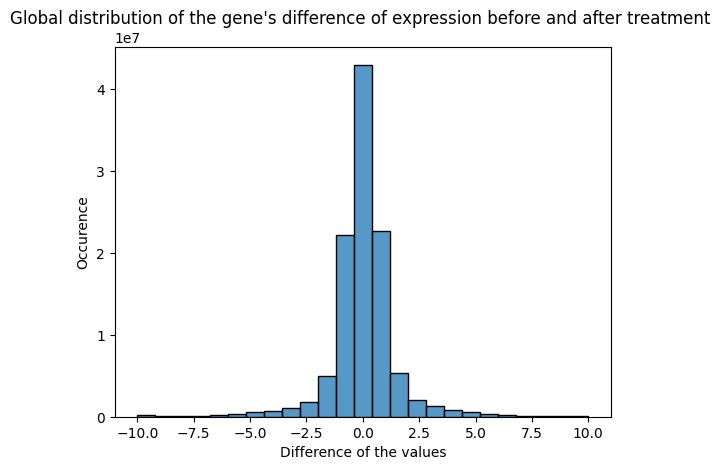

In [5]:
import seaborn as sns
distribution = outlier
sns.histplot(distribution.to_numpy().flatten(),bins = 25)
plt.title("Global distribution of the gene's difference of expression before and after treatment ")
plt.xlabel("Difference of the values")
plt.ylabel("Occurence")

This is the representation of the global distribution (accross all genes and all treatments) of the dataset, it follows a narrow centered at zero gaussian distribution.

We interpret this as :  

-- The majority of the genes remain stable after the treatment.

-- Balanced up and down regulation.

-- No systemic bias.

-- The dataset shows no batch artifacts or toxic global effects.


# 4 Change specific plot

Here we plotted the heatmap of the values in order to perhaps see trends in the change of genes expression, I applied a convolution because otherwise the function was too intensive to run on a colab with using an A100 from NVIDIA

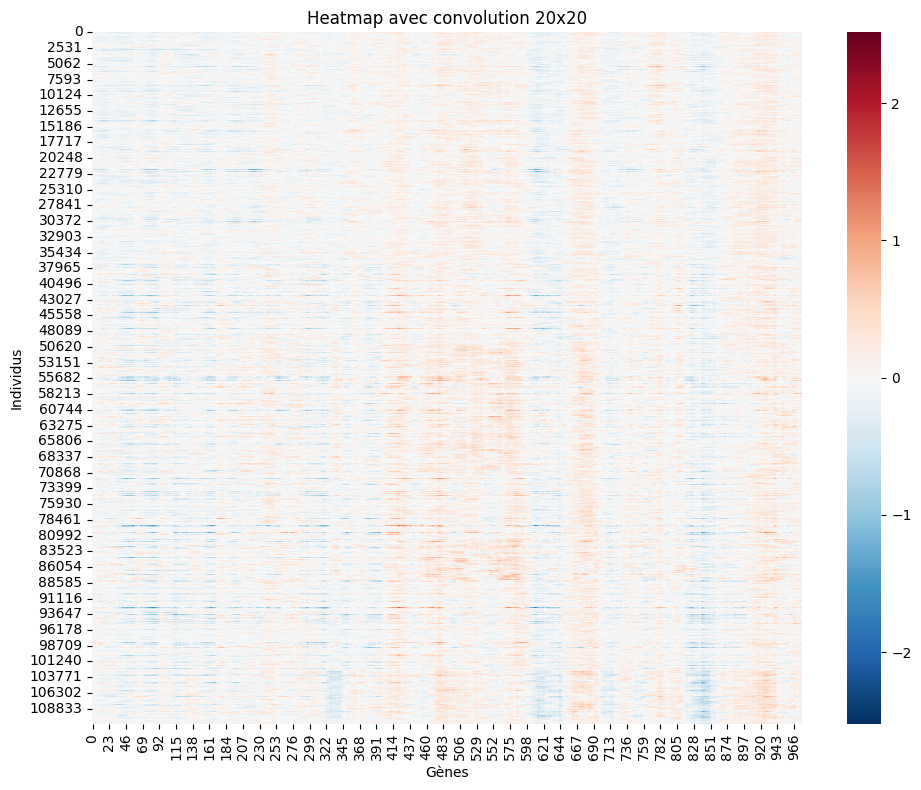

In [8]:

from scipy.signal import convolve2d
def heatmap(df):

  mat = df.values

  kernel_size = 20
  kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)

  smoothed = convolve2d(mat, kernel, mode='same')

  plt.figure(figsize=(10, 8))
  sns.heatmap(smoothed, cmap="RdBu_r", center=0)
  plt.title(f"Heatmap with convolution {kernel_size}x{kernel_size}")
  plt.xlabel("Genes")
  plt.ylabel("Individuals")
  plt.tight_layout()
  plt.show()
heatmap(outlier)

Most genes have a consistent reaction (either positive or negative) when faced  with many potential perturbations. The occurence of strong positive and negative answer within a gene is rare.
Furthermore, there are not many clusters within the individuals (we believe that this is mainly due to the variety of different treatment).

The following plot displays the variance for each gene, there are thus genes with a much higher variance than others. We choose to display the ids of only ten genes otherwise the plot would have been unreadable.

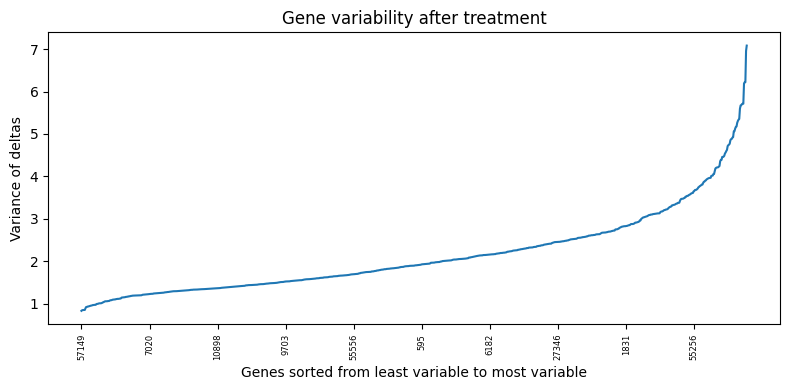

In [16]:

def plot_variance_gene(df, step=100):
    var_sorted = df.var().sort_values()
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(var_sorted)), var_sorted.values)
    ticks = np.arange(0, len(var_sorted), step)
    plt.xticks(ticks, var_sorted.index[ticks], rotation=90, fontsize=6)

    plt.xlabel("Genes sorted from least variable to most variable")
    plt.ylabel("Variance of deltas")
    plt.title("Gene variability after treatment")
    plt.tight_layout()
    plt.show()

plot_variance_gene(outlier, step=100)


The following plot will be a boxplot of response averaged on the whole population. The goal is to understand to which extent there are the reactions of people are strong or not when confronted to a any treatment.

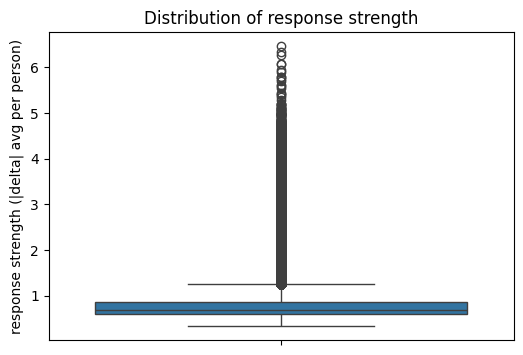

In [19]:

def absolute_box_plot(df):
  scores = pd.DataFrame(index=df.index)
  scores["mean_abs_delta"]   = df.abs().mean(axis=1)
  scores["median_abs_delta"] = df.abs().median(axis=1)
  scores["max_abs_delta"]    = df.abs().max(axis=1)


  plt.figure(figsize=(6,4))
  sns.boxplot(y=scores["mean_abs_delta"])
  plt.ylabel("response strength (|delta| avg per person)")
  plt.title("Distribution of response strength")
  plt.show()
absolute_box_plot(outlier)


Most individuals have weak to moderate treatment responses, with average absolute deltas close to 0.8.
A minority of individuals show very large responses (deltas above 2–6), producing a long right tail.
This indicates that response strength is highly heterogeneous across treatments: most perturbations induce modest changes, but a subset produces very strong, widespread effects on gene expression.